In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2
    
import os
import time
import sys
from datetime import datetime
from datetime import timedelta
from dateutil import relativedelta

#import warnings


sys.path.append('../') #needed to import utils.py

import utils

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn as sk

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline  


---
### Read data from `Pre-processed` CSV and `Riluzole` csv file

##### Read  `pre-processed` CSV file

In [2]:
#set the data directory
data_dir = os.path.abspath('../03_proact_preprocessed/')

#set the name of CSV file
data_file = f'{data_dir}/_patient.csv'

#read data and show some info
df_main = pd.read_csv(data_file, delimiter=',')
df_main

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Event_Dead,Event_Dead_Time_from_Onset,Group_Survival,Group_Survival_Coded
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,21.0,Slow,0.0,34.0,0-39,0.0,False,65.0,Long,0.0
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,6.0,Rapid,2.0,51.0,50-59,2.0,False,29.0,NaN,NaN
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,32.0,Slow,0.0,63.0,60-69,3.0,False,46.0,NaN,NaN
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,6.0,Rapid,2.0,61.0,60-69,3.0,False,23.0,NaN,NaN
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,2.0,Rapid,2.0,43.0,40-49,1.0,True,43.0,Average,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,11.0,Average,1.0,62.0,60-69,3.0,False,17.0,NaN,NaN
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,17.0,Average,1.0,66.0,60-69,3.0,False,25.0,NaN,NaN
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,16.0,Average,1.0,57.0,50-59,2.0,False,31.0,NaN,NaN
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,4.0,Rapid,2.0,49.0,40-49,1.0,False,9.0,NaN,NaN


##### Read RAW `Riluzole` CSV file and show some stats

In [3]:
#set the data directory
data_dir = os.path.abspath('../01_proact_raw_data_2022')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_RILUZOLE.csv'

#read data and show some info
df_raw = pd.read_csv(data_file, delimiter=',')

utils.show_columns_stats(df_raw) 

subject_id........... =  9478 rows (100.0%)     0 with NaN (  0.0%) Uniques=  9478 
Subject_used_Riluzole =  9478 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Riluzole_use_Delta... =  9456 rows (99.77%)    22 with NaN ( 0.23%) Uniques=   441 


##### Rename some columns

In [4]:
df_raw.rename(
    columns={
        "Subject_used_Riluzole": "Riluzole", 
        "Riluzole_use_Delta": "Riluzole_Delta", 
    }, 
    inplace=True
)

utils.show_columns_stats(df_raw) 

subject_id.... =  9478 rows (100.0%)     0 with NaN (  0.0%) Uniques=  9478 
Riluzole...... =  9478 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Riluzole_Delta =  9456 rows (99.77%)    22 with NaN ( 0.23%) Uniques=   441 


### Join the 2 datasets 

In [5]:
df = utils.join_datasets_by_key(df_main=df_main, df_to_join=df_raw, key_name='subject_id', how='left')
df

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Event_Dead,Event_Dead_Time_from_Onset,Group_Survival,Group_Survival_Coded,Riluzole,Riluzole_Delta
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,0.0,34.0,0-39,0.0,False,65.0,Long,0.0,NaN,NaN
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,2.0,51.0,50-59,2.0,False,29.0,NaN,NaN,Yes,0.0
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,0.0,63.0,60-69,3.0,False,46.0,NaN,NaN,NaN,NaN
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,2.0,61.0,60-69,3.0,False,23.0,NaN,NaN,No,0.0
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,2.0,43.0,40-49,1.0,True,43.0,Average,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,1.0,62.0,60-69,3.0,False,17.0,NaN,NaN,Yes,NaN
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,1.0,66.0,60-69,3.0,False,25.0,NaN,NaN,NaN,NaN
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,1.0,57.0,50-59,2.0,False,31.0,NaN,NaN,NaN,NaN
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,2.0,49.0,40-49,1.0,False,9.0,NaN,NaN,NaN,NaN


####  VERIFY HOW MUCH HAVE RILUZOLE_DELTA ">", "<" OR "=" TO ZERO

In [6]:
# VERIFY HOW MUCH HAVE RILUZOLE_DELTA ">", "<" OR "=" TO ZERO

tot = df.shape[0]

qtd = df.loc[
    (df.Riluzole_Delta.isnull() == False)
    &(df.Riluzole_Delta == 0 )
].shape[0]
print(f'= 0: {qtd:>4} {qtd/tot*100:>6.2f}%')

qtd = df.loc[
    (df.Riluzole_Delta.isnull() == False)
    &(df.Riluzole_Delta > 0 )
].shape[0]
print(f'> 0: {qtd:>4} {qtd/tot*100:>6.2f}%')

qtd = df.loc[
    (df.Riluzole_Delta.isnull() == False)
    &(df.Riluzole_Delta < 0 )
].shape[0]
print(f'< 0: {qtd:>4} {qtd/tot*100:>6.2f}%')


= 0: 2831  54.13%
> 0:   28   0.54%
< 0:  606  11.59%


----
----
----
## Replace `NaN` values in `Riluzole` column to "`No`" and `Riluzole-Delta` to "`0`"

In [7]:
df.loc[(df.Riluzole.isnull()==True), 'Riluzole'] = 'No'

df.loc[(df.Riluzole_Delta.isnull()==True), 'Riluzole_Delta'] = 0.0

df


,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Event_Dead,Event_Dead_Time_from_Onset,Group_Survival,Group_Survival_Coded,Riluzole,Riluzole_Delta
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,0.0,34.0,0-39,0.0,False,65.0,Long,0.0,No,0.0
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,2.0,51.0,50-59,2.0,False,29.0,NaN,NaN,Yes,0.0
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,0.0,63.0,60-69,3.0,False,46.0,NaN,NaN,No,0.0
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,2.0,61.0,60-69,3.0,False,23.0,NaN,NaN,No,0.0
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,2.0,43.0,40-49,1.0,True,43.0,Average,1.0,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,1.0,62.0,60-69,3.0,False,17.0,NaN,NaN,Yes,0.0
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,1.0,66.0,60-69,3.0,False,25.0,NaN,NaN,No,0.0
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,1.0,57.0,50-59,2.0,False,31.0,NaN,NaN,No,0.0
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,2.0,49.0,40-49,1.0,False,9.0,NaN,NaN,No,0.0


### Convert `Riluzole` column to `Boolean` datatype

In [8]:
df.Riluzole = df.Riluzole.map( {'Yes':True ,'No':False}) 
df

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Event_Dead,Event_Dead_Time_from_Onset,Group_Survival,Group_Survival_Coded,Riluzole,Riluzole_Delta
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,0.0,34.0,0-39,0.0,False,65.0,Long,0.0,False,0.0
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,2.0,51.0,50-59,2.0,False,29.0,NaN,NaN,True,0.0
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,0.0,63.0,60-69,3.0,False,46.0,NaN,NaN,False,0.0
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,2.0,61.0,60-69,3.0,False,23.0,NaN,NaN,False,0.0
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,2.0,43.0,40-49,1.0,True,43.0,Average,1.0,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,1.0,62.0,60-69,3.0,False,17.0,NaN,NaN,True,0.0
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,1.0,66.0,60-69,3.0,False,25.0,NaN,NaN,False,0.0
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,1.0,57.0,50-59,2.0,False,31.0,NaN,NaN,False,0.0
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,2.0,49.0,40-49,1.0,False,9.0,NaN,NaN,False,0.0


----
----
----
## Plot distribution for `Riluzole` column

Column: Riluzole  (DataType: object)
N         = 5230 [Non-NaN: 5230]
Missingness: 0 (0.0%)

Summary Table:
     count percentage
YES   2901     55.47%
NO    2329     44.53%


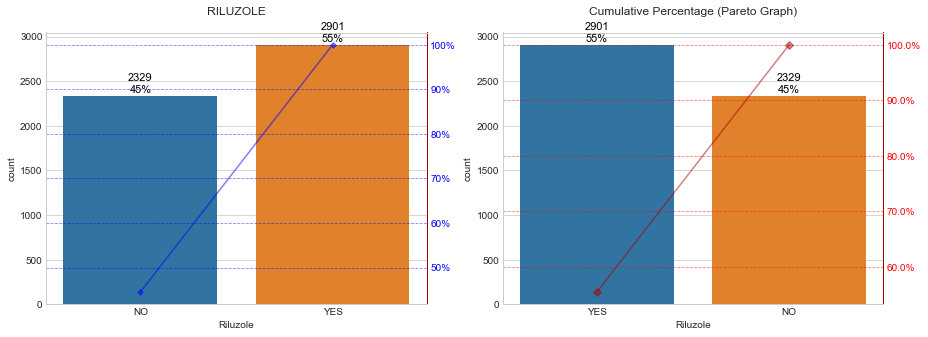

In [10]:
utils.plot_variable_distribution(series=df.Riluzole, print_more_info=True)

### Calculate time from symptoms onset

In [11]:
#calculate in DAYS
df['Riluzole_from_Onset_in_Days'] = df.Riluzole_Delta + np.abs(df.Symptoms_Onset_Delta)

#calculate in MONTHS
df['Riluzole_Time_from_Onset'] = np.NaN
in_months = df['Riluzole_from_Onset_in_Days'].apply( lambda x: utils.calculate_months_from_days(x)) 
df.loc[df.index,'Riluzole_Time_from_Onset'] = in_months

df

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Event_Dead,Event_Dead_Time_from_Onset,Group_Survival,Group_Survival_Coded,Riluzole,Riluzole_Delta,Riluzole_from_Onset_in_Days,Riluzole_Time_from_Onset
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,0-39,0.0,False,65.0,Long,0.0,False,0.0,1706.0,56
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,50-59,2.0,False,29.0,NaN,NaN,True,0.0,501.0,16
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,60-69,3.0,False,46.0,NaN,NaN,False,0.0,1023.0,33
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,60-69,3.0,False,23.0,NaN,NaN,False,0.0,715.0,23
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,40-49,1.0,True,43.0,Average,1.0,False,0.0,1070.0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,60-69,3.0,False,17.0,NaN,NaN,True,0.0,426.0,14
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,60-69,3.0,False,25.0,NaN,NaN,False,0.0,651.0,21
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,50-59,2.0,False,31.0,NaN,NaN,False,0.0,838.0,27
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,40-49,1.0,False,9.0,NaN,NaN,False,0.0,155.0,5


### Show total of samples non-NaN (and NaN) for each column

In [12]:
utils.show_columns_stats(df)

subject_id....................... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  5230 
Sex.............................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Qty_Measurements_ALSFRS.......... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    32 
Qty_Measurements_VITALSIGNS...... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    55 
Qty_Measurements_FVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    20 
Qty_Measurements_SVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    17 
Qty_Measurements_LABS............ =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   953 
Qty_Measurements_HANDGRIPSTRENGTH =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    38 
Qty_Measurements_MUSCLESTRENGTH.. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   293 
Qty_Measurements................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1087 
Symptoms_Onset_Delta............. =  523

### Drop unnecessary columns

In [13]:
df.drop(
    columns=[
        'Riluzole_Delta', 
        'Riluzole_from_Onset_in_Days',
    ], 
    inplace=True,
)

utils.show_columns_stats(df) 

subject_id....................... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  5230 
Sex.............................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Qty_Measurements_ALSFRS.......... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    32 
Qty_Measurements_VITALSIGNS...... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    55 
Qty_Measurements_FVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    20 
Qty_Measurements_SVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    17 
Qty_Measurements_LABS............ =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   953 
Qty_Measurements_HANDGRIPSTRENGTH =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    38 
Qty_Measurements_MUSCLESTRENGTH.. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   293 
Qty_Measurements................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1087 
Symptoms_Onset_Delta............. =  523

----
----
----
# Save the pre-processed data to CSV file

In [14]:
dir_dest = os.path.abspath('../03_proact_preprocessed/')
csv_dest = f'{dir_dest}/_patient.csv'

utils.save_to_csv(df=df, csv_file=csv_dest)


5230 samples were saved


### ######################################################################################
### ######################################################################################
### ######################################################################################

